## Test the EfficientNet for CIFAR-10 datasets

In [1]:
import keras

Using TensorFlow backend.


## We use pretrained model for ImageNet for finetuning for CIFAR-10 datasets. First install efficientnet package

In [2]:
! python3 -m pip install efficientnet

## Load EfficientNet model

In [3]:
import efficientnet.keras as eff

In [ ]:
net=eff.EfficientNetB0(include_top=False,weights='imagenet',input_shape=(224,224,3),classes=10)

16809984/16804768 [==============================] - 2s 0us/step


In [ ]:
net.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [ ]:
model=keras.models.Sequential()
model.add(net)
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(10,activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                12810     
Total params: 4,062,374
Trainable params: 4,020,358
Non-trainable params: 42,016
_________________________________________________________________


In [ ]:
import tensorflow as tf

In [ ]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [ ]:
from EfficientNet import CustomGenerator

In [ ]:
train_gen=CustomGenerator(x_train,y_train,batch_size=8,augment=True)
test_gen=CustomGenerator(x_test,y_test,shuffle=False,batch_size=8,augment=False)

## Train the classifier

In [ ]:
net.trainable=False

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
sgd=keras.optimizers.SGD(learning_rate=1e-3,momentum=0.9,nesterov=True)
es=keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',patience=10,restore_best_weights=True,verbose=1)
rlrop=keras.callbacks.ReduceLROnPlateau(monitor='val_loss',mode='min',patience=5,factor=0.5,min_lr=1e-6,verbose=1)

In [ ]:
model.compile(optimizer=sgd,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
hist_1=model.fit_generator(generator=train_gen,validation_data=test_gen,epochs=10,callbacks=[es,rlrop])

Epoch 1/10
6250/6250 [==============================] - 839s 134ms/step - loss: 1.3953 - accuracy: 0.5287 - val_loss: 2.3602 - val_accuracy: 0.3769
Epoch 2/10
6250/6250 [==============================] - 835s 134ms/step - loss: 1.1932 - accuracy: 0.5908 - val_loss: 2.4926 - val_accuracy: 0.3661
Epoch 3/10
6250/6250 [==============================] - 819s 131ms/step - loss: 1.1565 - accuracy: 0.6010 - val_loss: 2.3714 - val_accuracy: 0.3909
Epoch 4/10
6250/6250 [==============================] - 824s 132ms/step - loss: 1.1428 - accuracy: 0.6078 - val_loss: 2.3740 - val_accuracy: 0.3917
Epoch 5/10
6250/6250 [==============================] - 831s 133ms/step - loss: 1.1399 - accuracy: 0.6066 - val_loss: 2.3981 - val_accuracy: 0.4027
Epoch 6/10
6250/6250 [==============================] - 825s 132ms/step - loss: 1.1296 - accuracy: 0.6090 - val_loss: 2.3211 - val_accuracy: 0.4018
Epoch 7/10
6250/6250 [==============================] - 822s 132ms/step - loss: 1.1266 - accuracy: 0.6132 - val_

## Evaluate model after training the classifier

In [ ]:
train_gen=CustomGenerator(x_train,y_train,shuffle=False,batch_size=8,augment=False)

In [ ]:
model.evaluate_generator(generator=train_gen,use_multiprocessing=True,verbose=1)

6250/6250 [==============================] - 398s 64ms/step


[2.3793296813964844, 0.4093399941921234]

In [ ]:
model.evaluate_generator(generator=test_gen,use_multiprocessing=True,verbose=1)

1250/1250 [==============================] - 79s 64ms/step


[2.1929917335510254, 0.4065000116825104]

In [ ]:
model.save('cifar10_first_stage.h5')

## Fine tuning model

In [ ]:
! unzip "/content/drive/My Drive/cifar10_first_stage.zip"

Archive:  /content/drive/My Drive/cifar10_first_stage.zip
  inflating: cifar10_first_stage.h5  


In [ ]:
model=keras.models.load_model('cifar10_first_stage.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                12810     
Total params: 4,062,374
Trainable params: 4,020,358
Non-trainable params: 42,016
_________________________________________________________________


### Define the learning rate schedule

In [ ]:
def lr_schedule(epoch):
  '''
  Learning rate schedule
  '''
  lr=1e-3
  factor=0.8
  return lr*factor**epoch

In [ ]:
lr_scheduler=keras.callbacks.LearningRateScheduler(lr_schedule,verbose=1)

In [ ]:
train_gen=CustomGenerator(x_train,y_train,shuffle=True,batch_size=8,augment=True)
test_gen=CustomGenerator(x_test,y_test,shuffle=False,batch_size=8,augment=False)

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
hist_2=model.fit_generator(generator=train_gen,epochs=10,callbacks=[lr_scheduler,es],validation_data=test_gen)

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
6250/6250 [==============================] - 1193s 191ms/step - loss: 0.9301 - accuracy: 0.6810 - val_loss: 0.2553 - val_accuracy: 0.8259
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 0.0008.
6250/6250 [==============================] - 1168s 187ms/step - loss: 0.6325 - accuracy: 0.7819 - val_loss: 0.2286 - val_accuracy: 0.8439
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to 0.0006400000000000002.
6250/6250 [==============================] - 1129s 181ms/step - loss: 0.4876 - accuracy: 0.8325 - val_loss: 0.0453 - val_accuracy: 0.8910
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to 0.0005120000000000001.
6250/6250 [==============================] - 1126s 180ms/step - loss: 0.3914 - accuracy: 0.8648 - val_loss: 0.0813 - val_accuracy: 0.9139
Epoch 5/10

Epoch 00005: LearningRateScheduler setting learning rate to 0.0004096000000000001.
6250

In [ ]:
model.save('cifar10-final.h5')

In [ ]:
train_gen=CustomGenerator(x_train,y_train,shuffle=False,batch_size=8,augment=False)

### Evaluate model

In [ ]:
model.evaluate_generator(train_gen,use_multiprocessing=True,verbose=1)

6250/6250 [==============================] - 201s 32ms/step


[0.024939775466918945, 0.9865599870681763]

In [ ]:
model.evaluate_generator(test_gen,use_multiprocessing=True,verbose=1)

1250/1250 [==============================] - 40s 32ms/step


[0.0628083348274231, 0.9444000124931335]

**Training accuracy: 98.66**

**Val accuracy: 94.44**

### Save history to text file

In [ ]:
print(hist_2.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


In [ ]:
with open('cifar_10.txt','w') as f:
  for value in hist_2.history['loss']:
    f.write(str(value)+' ')
  f.write('\n')
  for value in hist_2.history['val_loss']:
    f.write(str(value)+' ')
  f.write('\n')
  for value in hist_2.history['accuracy']:
    f.write(str(value)+' ')
  f.write('\n')
  for value in hist_2.history['val_accuracy']:
    f.write(str(value)+' ')

### Make prediction

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
labels=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [ ]:
indexes=np.random.randint(low=0,high=9999,size=(8,))

In [ ]:
pred_images=x_test[indexes]

In [ ]:
pred_labels=y_test[indexes]

In [ ]:
def prediction(images,model,labels):
  '''
  Make a prediction
  Parameters:
  images: 3D tensor for predict 1 image or 4D tensor for predict multiple images
  '''
  if(len(images.shape)==3):
    images=images.reshape(1,images.shape[0],images.shape[1],images.shape[2])
  pred_gen=CustomGenerator(images,labels,shuffle=False,batch_size=8,augment=False)
  pred=model.predict_generator(pred_gen,use_multiprocessing=True,verbose=1)
  pred=np.argmax(pred,axis=1)
  print('Prediction: ')
  print(pred)
  print('Ground truth: ')
  print(labels)
  return pred

In [ ]:
pred=prediction(pred_images,model,pred_labels)

1/1 [==============================] - 0s 135ms/step
Prediction: 
[9 9 0 1 3 1 2 7]
Ground truth: 
[[9]
 [9]
 [0]
 [1]
 [3]
 [1]
 [2]
 [7]]


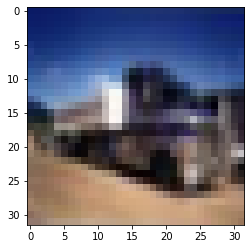

truck


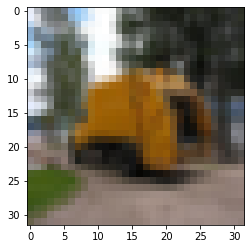

truck


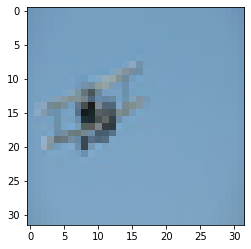

airplane


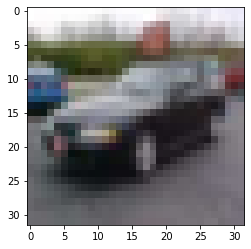

automobile


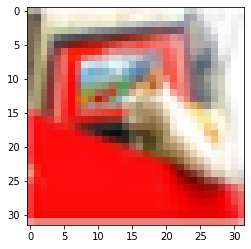

cat


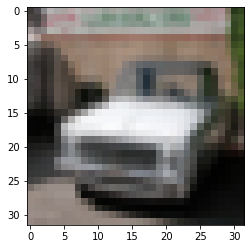

automobile


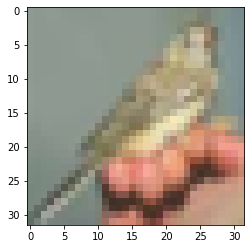

bird


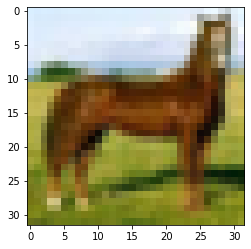

horse


In [ ]:
%matplotlib inline
for i in range(len(pred_images)):
  plt.imshow(pred_images[i])
  plt.show()
  print(labels[pred[i]])

## Do the same for CIFAR-100

In [4]:
net=eff.EfficientNetB0(include_top=False,weights='imagenet',input_shape=(224,224,3),classes=100)

16809984/16804768 [==============================] - 1s 0us/step


In [5]:
import tensorflow as tf
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.cifar100.load_data()

169009152/169001437 [==============================] - 6s 0us/step


In [6]:
model=keras.models.Sequential()
model.add(net)
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(100,activation='softmax'))

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               128100    
Total params: 4,177,664
Trainable params: 4,135,648
Non-trainable params: 42,016
_________________________________________________________________


In [9]:
from EfficientNet import CustomGenerator

In [10]:
train_gen=CustomGenerator(x_train,y_train,batch_size=8,augment=True)
test_gen=CustomGenerator(x_test,y_test,shuffle=False,batch_size=8,augment=False)

In [11]:
sgd=keras.optimizers.SGD(learning_rate=1e-3,momentum=0.9,nesterov=True)
es=keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',patience=10,restore_best_weights=True,verbose=1)
rlrop=keras.callbacks.ReduceLROnPlateau(monitor='val_loss',mode='min',patience=5,factor=0.5,min_lr=1e-6,verbose=1)

In [12]:
net.trainable=False

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               128100    
Total params: 4,177,664
Trainable params: 128,100
Non-trainable params: 4,049,564
_________________________________________________________________


In [14]:
model.compile(optimizer=sgd,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [15]:
hist_1=model.fit_generator(train_gen,epochs=15,validation_data=test_gen,callbacks=[es,rlrop])

Epoch 1/15
6250/6250 [==============================] - 755s 121ms/step - loss: 3.8750 - accuracy: 0.1770 - val_loss: 3.4290 - val_accuracy: 0.1460
Epoch 2/15
6250/6250 [==============================] - 769s 123ms/step - loss: 3.1050 - accuracy: 0.2988 - val_loss: 3.1092 - val_accuracy: 0.1657
Epoch 3/15
6250/6250 [==============================] - 783s 125ms/step - loss: 2.8385 - accuracy: 0.3340 - val_loss: 3.1000 - val_accuracy: 0.1690
Epoch 4/15
6250/6250 [==============================] - 800s 128ms/step - loss: 2.7038 - accuracy: 0.3499 - val_loss: 3.0059 - val_accuracy: 0.1792
Epoch 5/15
6250/6250 [==============================] - 781s 125ms/step - loss: 2.6154 - accuracy: 0.3639 - val_loss: 3.0464 - val_accuracy: 0.1813
Epoch 6/15
6250/6250 [==============================] - 785s 126ms/step - loss: 2.5559 - accuracy: 0.3721 - val_loss: 3.1243 - val_accuracy: 0.1889
Epoch 7/15
6250/6250 [==============================] - 754s 121ms/step - loss: 2.5125 - accuracy: 0.3816 - val_

In [16]:
model.save('cifar100_stage_1.h5')

In [17]:
new_model=keras.models.load_model('cifar100_stage_1.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [18]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               128100    
Total params: 4,177,664
Trainable params: 4,135,648
Non-trainable params: 42,016
_________________________________________________________________


In [19]:
def lr_schedule(epoch):
  '''
  Learning rate schedule
  '''
  lr=1e-3
  factor=0.8
  return lr*factor**epoch

In [20]:
lr_scheduler=keras.callbacks.LearningRateScheduler(lr_schedule,verbose=1)

In [21]:
train_gen=CustomGenerator(x_train,y_train,shuffle=True,batch_size=8,augment=True)
test_gen=CustomGenerator(x_test,y_test,shuffle=False,batch_size=8,augment=False)

In [ ]:
new_model=keras.models.load_model('cifar100_stage_1.h5')

In [22]:
new_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
hist_2=new_model.fit_generator(train_gen,epochs=15,validation_data=test_gen,callbacks=[lr_scheduler,es])

Epoch 1/15

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
6250/6250 [==============================] - 1624s 260ms/step - loss: 2.2965 - accuracy: 0.3991 - val_loss: 3.9654 - val_accuracy: 0.5211
Epoch 2/15

Epoch 00002: LearningRateScheduler setting learning rate to 0.0008.
6250/6250 [==============================] - 1620s 259ms/step - loss: 1.7174 - accuracy: 0.5295 - val_loss: 2.9790 - val_accuracy: 0.6129
Epoch 3/15

Epoch 00003: LearningRateScheduler setting learning rate to 0.0006400000000000002.
6250/6250 [==============================] - 1637s 262ms/step - loss: 1.4092 - accuracy: 0.6055 - val_loss: 2.5939 - val_accuracy: 0.6734
Epoch 4/15

Epoch 00004: LearningRateScheduler setting learning rate to 0.0005120000000000001.
6250/6250 [==============================] - 1612s 258ms/step - loss: 1.1797 - accuracy: 0.6636 - val_loss: 2.9063 - val_accuracy: 0.6932
Epoch 5/15

Epoch 00005: LearningRateScheduler setting learning rate to 0.0004096000000000001.
6250